# Enviroment

## Installations

In [4]:
#!pip install beautifulsoup4
#!pip install pandas
#!pip3 install bs4

## Imports

In [153]:
# Data manipulation
import pandas as pd
import numpy as np
import math
import re

# Screaping
from   bs4 import BeautifulSoup
import requests

# Time
from datetime import datetime
from time import sleep

# Visualization
from tabulate import tabulate
from IPython.display import Image

# DataBase
import sqlite3
from sqlalchemy import create_engine

## Functions

### BeautifullSoup

In [3]:
def clean_html(input_html):
    '''
    Remove spaces and "/n" caracters
    
    :param input_html: BeautifulSoup object to clean
    
    return New object without /n and spaces
    '''
    return ' '.join(input_html.split()).replace('> <', '><')

### Database Query

In [14]:
def query_db(query=None, database='hm_db.sqlite'):
    '''
    --> Do a database query
    
    :param query: SQL command to be executed
    :param database: Database to manipulate
    '''
    conn = sqlite3.connect(database)
    cursor = conn.execute(query)
    conn.commit()
    conn.close()

In [53]:
def query_visualization_db(query=None, database='hm_db.sqlite'):
    '''
    --> Do a database query and return an visualization
    
    :param query: SQL command to be executed
    :param database: Database to manipulate
    '''
    conn = create_engine(f'sqlite:///{database}', echo=False)
    display(pd.read_sql(query, conn))
    conn.close()

# Web Scraping

## Beautifull Soup

### Step 1

Top page

In [43]:
# Request informations
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
page = requests.get(url, headers=headers)

# BeautifulSoup html page
soup = BeautifulSoup(page.text, 'html.parser')

# BeautifulSoup html products content
products = soup.find('ul', class_="products-listing small")
product_list = products.find_all('article', class_='hm-product-item')

# product id
product_id = [p.get('data-articlecode') for p in product_list]

# product category
product_category = [p.get('data-category') for p in product_list]

# product names
products_names = products.find_all('a', class_ = 'link')
products_names = [p.get_text() for p in products_names]

# product price
product_price = products.find_all('span', class_ = 'price regular')
product_price = [p.get_text() for p in product_price]

# DataFrame with scrapy data
data = pd.DataFrame([product_id, products_names, product_category, product_price]).T
data.columns = ['product_id', 'name', 'category', 'price']
data['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d %H-%M-%S')

In [45]:
data.head()

,product_id,name,category,price,scrapy_datetime
0,0985197001,Slim Jeans,men_jeans_slim,$ 19.99,2021-11-17 10-11-07
1,0985159001,Skinny Jeans,men_jeans_skinny,$ 19.99,2021-11-17 10-11-07
2,0690449051,Skinny Jeans,men_jeans_ripped,$ 39.99,2021-11-17 10-11-07
3,0690449022,Skinny Jeans,men_jeans_ripped,$ 39.99,2021-11-17 10-11-07
4,0690449043,Skinny Jeans,men_jeans_ripped,$ 39.99,2021-11-17 10-11-07


In [11]:
# product color

In [12]:
# product composition

### Step 2

Paginations

In [12]:
# Request informations
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
page = requests.get(url, headers=headers)

# BeautifulSoup html page
soup = BeautifulSoup(page.text, 'html.parser')

In [13]:
total_items = int(soup.find('h2', class_ = 'load-more-heading').get('data-total'))
total_items

85

In [14]:
# How to round to upper number
page_number = math.ceil(total_items / 36)
page_number

3

In [15]:
url_2 = url + '?page-size=' + str(page_number * 36)
url_2

'https://www2.hm.com/en_us/men/products/jeans.html?page-size=108'

### Step 3

Specific product page (subpage)

#### One Product

In [17]:
#------------------------------API Request----------------------------
url = 'https://www2.hm.com/en_us/productpage.0690449051.html'
header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
page = requests.get(url, headers=header).text

#------------------------------BeautifulSoup Object--------------------
soup = BeautifulSoup(page)

#------------------------------Product Color---------------------------

product_detail = soup.find_all('a', class_ = 'filter-option miniature')
product_color = [p.get('data-color') for p in product_detail]
product_code = [p.get('data-articlecode') for p in product_detail]

df_color = pd.DataFrame({'product_code': product_code, 'product_color': product_color})
df_color['color_id'] = df_color['product_code'].apply(lambda x: x[-3:])
df_color['style_id'] = df_color['product_code'].apply(lambda x: x[:-3])
df_color.head()

,product_code,product_color,color_id,style_id
0,0690449001,Light denim blue/trashed,001,0690449
1,0690449002,Denim blue,002,0690449
2,0690449006,Black/washed,006,0690449
3,0690449007,Light denim blue,007,0690449
4,0690449009,Black washed out,009,0690449


In [18]:
#------------------------------Product Composition---------------------------
product_composition = [list(filter(None, p.get_text().split('\n'))) for p in soup.find_all('div', class_ = 'pdp-description-list-item')]

df_composition = pd.DataFrame(product_composition).T
df_composition.columns = df_composition.iloc[0]
df_composition.drop(index=0, inplace=True)

df_composition = df_composition[['Fit', 'Composition', 'Art. No.']]
df_composition.columns = df_composition.columns.str.lower()
df_composition.columns = ['fit', 'composition', 'product_code']
df_composition.fillna(method='ffill', inplace=True)
df_composition['style_id'] = df_composition['product_code'].apply(lambda x: x[:-3])
df_composition['color_id'] = df_composition['product_code'].apply(lambda x: x[-3:])
df_composition

,fit,composition,product_code,style_id,color_id
1,Skinny fit,"Cotton 98%, Spandex 2%",0690449051,0690449,051


In [4]:
#------------------------------SKU Product---------------------------
df_sku = pd.merge(df_color, df_composition[['style_id', 'fit', 'composition']], how='left', on='style_id')
df_sku

,product_code,product_color,color_id,style_id,fit,composition
0,0690449001,Light denim blue/trashed,001,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
1,0690449002,Denim blue,002,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
2,0690449006,Black/washed,006,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
3,0690449007,Light denim blue,007,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
4,0690449009,Black washed out,009,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
5,0690449011,White,011,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
6,0690449013,Black/washed,013,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
7,0690449021,Dark denim blue/trashed,021,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
8,0690449022,Black/trashed,022,0690449,Skinny fit,"Cotton 98%, Elastane 2%"
9,0690449024,Dark blue/Trashed,024,0690449,Skinny fit,"Cotton 98%, Elastane 2%"


#### All products

In [66]:
#------------------------------API Request----------------------------
header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
# URL model = 'https://www2.hm.com/en_us/productpage + product code + .html'

df_details = pd.DataFrame()
columns_available = list()
df_pattern = pd.DataFrame(columns=['Art. No.', 'Composition', 'Fit', 'More sustainable materials', 'Size'])

for i in range(len(data)):
    # URL composition and request
    url = f"https://www2.hm.com/en_us/productpage.{data.loc[i, 'product_id']}.html"
    page = requests.get(url, headers=header).text
    
    #------------------------------BeautifulSoup Object--------------------
    soup = BeautifulSoup(page)

    #------------------------------Product Color---------------------------

    product_detail = soup.find_all('a', class_ = 'filter-option miniature')
    product_color = [p.get('data-color') for p in product_detail]
    product_code = [p.get('data-articlecode') for p in product_detail]

    df_color = pd.DataFrame({'product_code': product_code, 'product_color': product_color})
    df_color['color_id'] = df_color['product_code'].apply(lambda x: x[-3:])
    df_color['style_id'] = df_color['product_code'].apply(lambda x: x[:-3])
    
    #------------------------------Product Composition---------------------------
    ## Get composition information
    product_composition = [list(filter(None, p.get_text().split('\n'))) for p in soup.find_all('div', class_ = 'pdp-description-list-item')]
    
    ## Composition to DataFrame
    df_composition = pd.DataFrame(product_composition).T
    df_composition.columns = df_composition.iloc[0]
    df_composition.drop(index=0, inplace=True)
    
    #columns_available = columns_available + df_composition.columns.to_list()
    
    ## Garantee the patters columns
    df_composition = pd.concat([df_pattern, df_composition])
    
    #df_composition = df_composition[['Fit', 'Composition', 'Art. No.']]
    
    # Rename columns and fill data below
    df_composition.columns = df_composition.columns.str.lower()
    df_composition.columns = ['product_code', 'composition', 'fit', 'sustainable_materials', 'size']
    df_composition.fillna(method='ffill', inplace=True)
    
    
    # Derivate new features
    df_composition['style_id'] = df_composition['product_code'].apply(lambda x: x[:-3])
    df_composition['color_id'] = df_composition['product_code'].apply(lambda x: x[-3:])
    
    
    #------------------------------SKU Product---------------------------
    df_sku = pd.merge(df_color, df_composition[['style_id', 'fit', 'composition', 'size', 'sustainable_materials']], 
                      how='left', on='style_id')
    
    
    #------------------------------All products--------------------------
    df_details = pd.concat([df_all_products, df_sku], axis=0)
    

# Join showroom data + details
data['style_id'] = data['product_id'].apply(lambda x: x[:-3])
data['color_id'] = data['product_id'].apply(lambda x: x[-3:])
data_raw = pd.merge(data, df_details[['style_id', 'product_color', 'fit', 'composition', 'size', 
                                      'sustainable_materials']], on='style_id', how='left')

In [75]:
# Save file
data_raw.to_csv('../data/products_hnm.csv', index=False)

## Exercises

### Collect the following information on the page: https://books.toscrape.com

- Catalog

    - Classics

    - Science Fiction

    - Humor

    - Business

- Collect the following information about the books:
    
    - Name of book
  
    - Price in pound
 
    - Rating
 
    - Stock information
 
### Deliverable
- A plan to all questions:
 
    - Output: The simulation of a table or final graph
 
    - Process: Step sequence organized by logical execution
 
    - Input: The link for data source
   
- A csv file with all collected information.

### Plan

<font size="3"><b>Output</b></font>

Columns in the table

Catalog | Name of Book | Price | Rating | Stocks Status

In [37]:
tab = [
    ['catalog', 'book_name', 'price', 'rating', 'stock_status'],
    ['Cassic', 'The Secret Garden', '£15.08', '4', 'In stock'],
    ['Science Fiction', 'Mesaerion', '£37.59', '1', 'In stock']
]

print(tabulate(tab, headers='firstrow'))

catalog          book_name          price      rating  stock_status
---------------  -----------------  -------  --------  --------------
Cassic           The Secret Garden  £15.08          4  In stock
Science Fiction  Mesaerion          £37.59          1  In stock


<font size="3"><b>Process</b></font>

Step 1: Create a soup object from the book collection page

Step 2: Identify book attribute tags for capture

Step 3: Get all the information from the book collection

Step 4: Repeat process for all book collections

Step 5: Create a DataFrame Pandas with all the information from the book collections

Step 6: Generate a csv file with the collected information

<font size="3"><b>Input</b></font>

<a href="https://books.toscrape.com/catalogue/category/books/classics_6/index.html">Classics</a> 

<a href="https://books.toscrape.com/catalogue/category/books/science-fiction_16/index.html">Science Fiction</a> 

<a href="https://books.toscrape.com/catalogue/category/books/humor_30/index.html">Humor</a> 

<a href="https://books.toscrape.com/catalogue/category/books/business_35/index.html">Business</a> 

#### Step 1 to 3

##### Top page

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}

In [76]:
# Request information

url_classics = 'https://books.toscrape.com/catalogue/category/books/classics_6/index.html'
page = requests.get(url_classics, headers=headers)

In [77]:
# Clean html
page = clean_html(page.text)

In [78]:
# BeautifulSoup object
soup = BeautifulSoup(page, 'html.parser')

In [144]:
# Name of collection
catalog = soup.find('h1').text

In [69]:
# Name of book
book_name = soup.find_all('h3')
book_name_list = [name.get_text() for name in book_name]
book_name_list

['The Secret Garden',
 'The Metamorphosis',
 "The Pilgrim's Progress",
 'The Hound of the ...',
 'Little Women (Little Women ...',
 'Gone with the Wind',
 'Candide',
 'Animal Farm',
 'Wuthering Heights',
 'The Picture of Dorian ...',
 'The Complete Stories and ...',
 'Beowulf',
 'And Then There Were ...',
 'The Story of Hong ...',
 'The Little Prince',
 'Sense and Sensibility',
 'Of Mice and Men',
 'Emma',
 "Alice in Wonderland (Alice's ..."]

In [70]:
# Price of book
prices = soup.find_all('p', class_ = 'price_color')
prices_list = [price.get_text() for price in prices]
prices_list

['Â£15.08',
 'Â£28.58',
 'Â£50.26',
 'Â£14.82',
 'Â£28.07',
 'Â£32.49',
 'Â£58.63',
 'Â£57.22',
 'Â£17.73',
 'Â£29.70',
 'Â£26.78',
 'Â£38.35',
 'Â£35.01',
 'Â£43.19',
 'Â£45.42',
 'Â£37.46',
 'Â£47.11',
 'Â£32.93',
 'Â£55.53']

In [72]:
# Stock
stock_prod = soup.find_all('p', class_ = 'instock availability')
stock_status_list = [stock.get_text() for stock in stock_prod]
stock_status_list

[' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ',
 ' In stock ']

In [121]:
soup.find_all('p', class_ = True)[3].attrs['class']

['star-rating', 'One']

In [129]:
# Rating
#soup.find_all('p', class_ = True)[0].attrs['class'][1]
ratings = soup.find_all('p', class_ = True)
rating_list = [r.attrs['class'] for r in ratings]
rating_list

[['star-rating', 'Four'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'One'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Two'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Two'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Four'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Three'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Three'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Three'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Three'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Two'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Four'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Two'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Two'],
 ['price_color'],
 ['instock', 'availability'],
 ['star-rating', 'Four'],
 ['price_color

In [143]:
rating_list_clean = list()
for i in range(0, len(rating_list), 3):
    rating_list_clean.append(rating_list[i][1])
rating_list_clean

['Four',
 'One',
 'Two',
 'Two',
 'Four',
 'Three',
 'Three',
 'Three',
 'Three',
 'Two',
 'Four',
 'Two',
 'Two',
 'Four',
 'Two',
 'One',
 'Two',
 'Two',
 'One']

In [137]:
rating_list[1]

['price_color']

In [146]:
pd.DataFrame({
    'catalog': catalog, 
    'book_name': book_name_list, 
    'price': prices_list, 
    'rating': rating_list_clean, 
    'stock_status': stock_status_list
})

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,Â£15.08,Four,In stock
1,Classics,The Metamorphosis,Â£28.58,One,In stock
2,Classics,The Pilgrim's Progress,Â£50.26,Two,In stock
3,Classics,The Hound of the ...,Â£14.82,Two,In stock
4,Classics,Little Women (Little Women ...,Â£28.07,Four,In stock
5,Classics,Gone with the Wind,Â£32.49,Three,In stock
6,Classics,Candide,Â£58.63,Three,In stock
7,Classics,Animal Farm,Â£57.22,Three,In stock
8,Classics,Wuthering Heights,Â£17.73,Three,In stock
9,Classics,The Picture of Dorian ...,Â£29.70,Two,In stock


##### Book Page

In [178]:
soup.find('article', class_ = 'product_pod')

<article class="product_pod"><div class="image_container"><a href="../../../the-dirty-little-secrets-of-getting-your-dream-job_994/index.html"><img alt="The Dirty Little Secrets of Getting Your Dream Job" class="thumbnail" src="../../../../media/cache/92/27/92274a95b7c251fea59a2b8a78275ab4.jpg"/></a></div><p class="star-rating Four"><i class="icon-star"></i><i class="icon-star"></i><i class="icon-star"></i><i class="icon-star"></i><i class="icon-star"></i></p><h3><a href="../../../the-dirty-little-secrets-of-getting-your-dream-job_994/index.html" title="The Dirty Little Secrets of Getting Your Dream Job">The Dirty Little Secrets ...</a></h3><div class="product_price"><p class="price_color">Â£33.34</p><p class="instock availability"><i class="icon-ok"></i> In stock </p><form><button class="btn btn-primary btn-block" data-loading-text="Adding..." type="submit">Add to basket</button></form></div></article>

#### Step 4 to 6

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}
df_books = pd.DataFrame()
html_collections = ['https://books.toscrape.com/catalogue/category/books/classics_6/index.html',
                   'https://books.toscrape.com/catalogue/category/books/science-fiction_16/index.html', 
                    'https://books.toscrape.com/catalogue/category/books/humor_30/index.html',
                    'https://books.toscrape.com/catalogue/category/books/business_35/index.html']

for html in html_collections:
    # Page request
    page = requests.get(html, headers=headers)
    
    # Clean html
    page = clean_html(page.text)
    
    # BeautifulSoup object
    soup = BeautifulSoup(page, 'html.parser')
    
    # Name of collection
    catalog = soup.find('h1').text
    
    # Name of book
    book_name = soup.find_all('h3')
    book_name_list = [name.get_text() for name in book_name]
    
    # Price of book
    prices = soup.find_all('p', class_ = 'price_color')
    prices_list = [price.get_text() for price in prices]
    
    # Rating
    ratings = soup.find_all('p', class_ = True)
    rating_list = [r.attrs['class'] for r in ratings]
    
    # Stock
    stock_prod = soup.find_all('p', class_ = 'instock availability')
    stock_status_list = [stock.get_text() for stock in stock_prod]
    rating_list_clean = list()
    for i in range(0, len(rating_list), 3):
        rating_list_clean.append(rating_list[i][1])
        
    df_catalog = pd.DataFrame({'catalog': catalog, 
                                'book_name': book_name_list, 
                                'price': prices_list, 
                                'rating': rating_list_clean, 
                                'stock_status': stock_status_list})
    
    df_books = pd.concat([df_books, df_catalog])

In [6]:
df_books.head()

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,Â£15.08,Four,In stock
1,Classics,The Metamorphosis,Â£28.58,One,In stock
2,Classics,The Pilgrim's Progress,Â£50.26,Two,In stock
3,Classics,The Hound of the ...,Â£14.82,Two,In stock
4,Classics,Little Women (Little Women ...,Â£28.07,Four,In stock


In [7]:
df_books.to_csv('../data/books.csv', index=False)

The top page don't get the book title properly

# Python Advanced

## Lambda

Recommended to local an simply function, without replication purpose

In [2]:
# Traditional function
def calc(a, b):
    return a + b

In [4]:
calc(2, 5)

7

In [5]:
# Lambda
cal_ = lambda a, b: a + b

In [6]:
cal_(2, 5)

7

## Map

Call a function to operate over a data struture

In [ ]:
#map(function, data_structure)

In [8]:
upper = ['MARCOS', 'GALVAO']

lower = lambda x: x.lower()

list(map(lower, upper))

['marcos', 'galvao']

## Apply

Work as same as Map, but specific to Pandas library

Map -> General use

Apply -> Pandas use

In [10]:
df = pd.DataFrame({
    'name': ['MARCOS', 'GALVAO'],
    'age': [30, 31]
})

In [12]:
df['name'].apply(lower)

0    marcos
1    galvao
Name: name, dtype: object

## Lambda, Map e Apply II

In [25]:
df_books.head()

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,Â£15.08,Four,In stock
1,Classics,The Metamorphosis,Â£28.58,One,In stock
2,Classics,The Pilgrim's Progress,Â£50.26,Two,In stock
3,Classics,The Hound of the ...,Â£14.82,Two,In stock
4,Classics,Little Women (Little Women ...,Â£28.07,Four,In stock


In [41]:
# Remove Â£ from price
df_books['price'] = df_books['price'].apply(lambda x: float(x.replace('Â£', '')))
df_books.head()

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,15.08,Four,In stock
1,Classics,The Metamorphosis,28.58,One,In stock
2,Classics,The Pilgrim's Progress,50.26,Two,In stock
3,Classics,The Hound of the ...,14.82,Two,In stock
4,Classics,Little Women (Little Women ...,28.07,Four,In stock


In [55]:
df_books[df_books['rating'] == 'Five'].head()

,catalog,book_name,price,rating,stock_status
1,Science Fiction,Join,35.67,Five,In stock
1,Humor,Old School (Diary of ...,11.83,Five,In stock
3,Humor,Hyperbole and a Half: ...,14.75,Five,In stock
6,Humor,When You Are Engulfed ...,30.89,Five,In stock
8,Humor,Lamb: The Gospel According ...,55.50,Five,In stock


In [54]:
# Increse price in 100% if the catalog is business and stock status is in 
 
df_books.apply(lambda x:  x['price'] * 2
               if (x['catalog'] == 'Business') & (x['rating'] == 'Five') 
               else x, axis=1).query('rating == "Five"').head()

,catalog,book_name,price,rating,stock_status
1,Science Fiction,Join,35.67,Five,In stock
1,Humor,Old School (Diary of ...,11.83,Five,In stock
3,Humor,Hyperbole and a Half: ...,14.75,Five,In stock
6,Humor,When You Are Engulfed ...,30.89,Five,In stock
8,Humor,Lamb: The Gospel According ...,55.50,Five,In stock


In [51]:
df_books['stock_status'][0]

0     In stock 
0     In stock 
0     In stock 
0     In stock 
Name: stock_status, dtype: object

## Regex - Regular Expression

<font size=5>**Marcadores de início e fim de linha (^ e $)**</font>


**^Python** – Encontra qualquer string que esteja em início de linha e contenham os caracteres “Python”. 

**Python$** – Encontra qualquer string que esteja em fim de linha e contenham os caracteres “Python”. 

<br/>
<br/>

<font size=5>**Marcadores de quantidade (* + ?  e {})**</font>
 

**Pyt*** – Encontra strings com a sequência de caracteres “Py” seguida de zero ou mais ocorrências do caractere “t”.

**Pyt+** – Encontra strings com a sequência de caracteres “Py” seguida de uma ou mais ocorrências do caractere “t”.

**Pyt?** –  Encontra strings com a sequência de caracteres “Py” seguida de zero ou uma ocorrência do caractere “t”.

**Pyt{3}** – Encontra strings com a sequência de caracteres “Py” seguida de exatamente 3 ocorrências do caractere “t”.

**Pyt{2, 4}** – Encontra strings com a sequência de caracteres “Py” seguida de 2 a 4 ocorrências do caractere “t”.

**Pyt{3,}** – Encontra strings com a sequência de caracteres “Py” seguida de 3 ou mais ocorrências do caractere “t”. 

**Py(th)*** – Encontra strings com a sequência de caracteres “Py” seguida de zero ou mais ocorrências do da sequência “th”. 
    
<br/>
<br/>

<font size=5>**Marcador de alternativa ou operador OR ( | )**</font>

**Pyt|hon** – Encontra strings com a sequência de caracteres “Pyt” ou strings com a sequência de caracteres “hon”. 

**Py(t|h)** – Encontra strings com a sequência de caracteres “Py” seguida do caractere “t” ou do caractere “h”. 

**Py(t|h|o)** – Encontra strings com a sequência de caracteres “Py” seguida do caractere “t” ou do caractere “h” ou do caractere “o”. 
    
<br/>
<br/>
    
<font size=5>**Marcador de definição de Conjuntos ([ ])**</font>

**Py[tho]** – Encontra strings com a sequência de caracteres “Py” seguida de um caractere pertencente ao conjunto (t, h, o). 

**Py[0-9]** – Encontra strings com a sequência de caracteres “Py” seguida de um caractere pertencente ao conjunto de dígitos de 0 a 9. 

**Py[a-z]** – Encontra strings com a sequência de caracteres “Py” seguida de um caractere pertencente ao conjunto de caracteres alfabéticos de “a” a “z”. 

<br/>
<br/>
    
<font size=5>**Marcadores de classes de caracteres (\w, \d, \s e .)**</font>
    
**\w** – Representa um caractere alfanumérico, incluindo ocorrências maiúsculas e minúsculas das letras e o caractere “_”.

**\d** – Representa um caractere numérico e equivale a definição do conjunto [0-9]

**\s** – Representa um espaço em branco, incluindo tabulações e quebras de linha

<br/>
<br/>
    
**.** – Como já mencionado, este caractere é utilizado como coringa e representa qualquer caractere.

A utilização de \W, \D e \S serve como negação de suas correspondentes descritas acima. \W vai encontrar, por exemplo, qualquer caractere que não seja relevante para \w.

### Match

    For begining of a string
    
    CPF 001.223.344-55
    
    sequency: number point number point number trace number
    padron: 3 numbers 1 point 3 numbers 1 point 3 numbers 1 trace 2 numbers 
    
    Regex mask colect the information based on the string padron

In [4]:
cpf = '001.223.344-55'
rg = '12.420.530-10'
cel = '+5522989527342'
address = 'Cecilia Chapman 711-2880 Nulla St. Mankato Mississippi 96522 (257) 563-7401'
address_2 = 'Calista Wise 7292 Dictum Av. San Antonio MI 47096 (492) 709-6392'

mask_cpf = '^\d{3}\.\d{3}\.\d{3}\-\d{2}$'

mask_rg = '^\d{2}\.\d{3}\.\d{3}\-\d{2}$'

mask_cel = '^\+\d{13}$'

mask_cel_inside = '\+\d{13}'

text = f'cpf: {cpf}, rg: {rg} and celphone is {cel}'

bool(re.match(mask_cel, text))

False

### Search

    Any text position

In [22]:
# Street

mask = '\w{2}\..*\d{5}'
mask_2 = '(\w{2}\..+)\s\('

print(re.search(mask_2, address_2).group(0))

Av. San Antonio MI 47096 (


In [21]:
# Name

mask = '^\w+\s\w+'

print(re.search(mask, address).group(0))

Cecilia Chapman


## Clean Data with Regex

In [195]:
data = pd.read_csv('../data/products_hnm.csv')
data = data[['product_id', 'name', 'category', 'price',
       'style_id', 'color_id', 'product_color', 'fit', 'composition', 'size',
       'sustainable_materials', 'scrapy_datetime']]

In [196]:
# name
data['name'] = data['name'].str.lower().str.replace(' ', '_')

# price
data['price'] = data['price'].apply(lambda x: float(x.replace('$ ', '')))

# scrapy_datetime
data['scrapy_datetime'] = pd.to_datetime(data['scrapy_datetime'])

# fit
data['fit'] = data['fit'].str.lower().str.replace(' ', '_')

# product color
data['product_color'] = data['product_color'].apply(lambda x: x.replace(' ', '_').replace('/', '_').lower())

# size number
data['size_number'] = data['size'].apply(lambda x: re.search('(\d{3})cm', x).group(1) if pd.notnull(x) else x)

# size model
data['size_model'] = data['size'].apply(lambda x: re.search('\d{2}/\d{2}', x).group(0) if pd.notnull(x) else x)

# drop columns
data.drop(columns=['size', 'sustainable_materials'], inplace=True)

# Ignore composition equal to Pocket lining, Shell and Pocket
data = data[~data['composition'].str.contains('Pocket lining', na=False)]
data = data[~data['composition'].str.contains('Shell', na=False)]
data = data[~data['composition'].str.contains('Pocket', na=False)]
data = data[~data['composition'].str.contains('Lining', na=False)]

# drop duplicates
data.drop_duplicates(inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)

In [197]:
# Decomposing the column composition
df_ref = pd.DataFrame(index=np.arange(len(data)), columns=['cotton'])

df_composition = data['composition'].str.split(',', expand=True).reset_index(drop=True)
df_composition = df_composition.apply(lambda x: x.str.strip())

# cotton
df_ref['cotton'] = df_composition[0]

# # spandex
df_ref['spandex'] = pd.Series(df_composition[df_composition[1].str.contains('Spandex', na=True)][1], name='spandex')
spandex_2 = pd.Series(df_composition[df_composition[2].str.contains('Spandex', na=True)][2], name='spandex_2')

# Assign spandex_2 with combine first
df_ref['spandex'] = df_ref['spandex'].combine_first(spandex_2)
# assigning values of spandex_2 in spandex
#for i in range(len(df_ref)):
#    if pd.isnull(df_ref['spandex'][i]) and pd.notnull(df_ref['spandex_2'][i]):
#        df_ref['spandex'][i] = df_ref['spandex_2'][i]

#elasterell-p
df_elasterell = pd.Series(df_composition[df_composition[1].str.contains('Elasterell-P', na=True)][1], name='elasterell-p')
df_ref = pd.concat([df_ref, df_elasterell], axis=1)

#polyester
df_polyester = pd.Series(df_composition[df_composition[1].str.contains('Polyester', na=True)][1], name='polyester')
df_ref = pd.concat([df_ref, df_polyester], axis=1)

#Join with new composition columns
data.reset_index(drop=True, inplace=True)
data = pd.concat([data, df_ref], axis=1)

#Composition with only numbers
data['cotton'] = data['cotton'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)
data['spandex'] = data['spandex'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)
data['elasterell-p'] = data['elasterell-p'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)
data['polyester'] = data['polyester'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)

#Drop original composition column
data.drop(columns='composition', inplace=True)

# Drop duplicates
data.drop_duplicates(inplace=True)

In [206]:
# Store file
data.to_csv('../data/clened.csv', index=False)

# Data Base

**SELECT** - Extract data from database

**UPDATE** - Update a data from a database

**DELETE** - Delete data from a database table, table structure remains

**INSERT INTO** - New record to database

**CREATE DATABASE** - Create new database

**ALTER DATABASE** - Modify a database

**CREATE TABLE** - Create a table

**ALTER TABLE** - Modify a table

**DROP TABLE** - Delete a table and the estrucuture

**CREATE INDEX** - Create and index (search key)

**DROP INDEX** - Delete and index

## Data Storage

### Database Creation

In [2]:
# Read data in csv format
data = pd.read_csv('../data/clened.csv')

In [11]:
query_showroom_table = '''
    CREATE TABLE products (
    'product_id'     INTEGER, 
    'name'           TEXT,
    'category'       TEXT,
    'price'          REAL,
    'style_id'       INTEGER,
    'color_id'       INTEGER, 
    'product_color'  TEXT, 
    'fit'            TEXT,
    'scrapy_datetime'TEXT, 
    'size_number'    REAL,
    'size_model'     TEXT,
    'cotton'         REAL,
    'spandex'        REAL,
    'elasterell-p'   REAL,
    'polyester'      REAL
    )
'''

In [45]:
# Connect to database
# create database and table
conn = sqlite3.connect('hm_db.sqlite')

cursor = conn.execute(query_showroom_table)
conn.commit()

OperationalError: table products already exists

In [16]:
# Engine connection
conn = create_engine('sqlite:///hm_db.sqlite', echo=False)

In [46]:
# Insert data to table
data.to_sql(name='products', con=conn, if_exists='append', index=False)

### Database querys

In [47]:
# command = '''
#     UPDATE products
#     SET category = 'tshirt'
#     WHERE product_id = 690449051
# '''

# command = '''
#     DROP TABLE products
# '''

# query_db(command)

query = '''
    SELECT * FROM products
'''

df = pd.read_sql(query, conn)
df.head()

,product_id,name,category,price,style_id,color_id,product_color,fit,scrapy_datetime,size_number,size_model,cotton,spandex,elasterell-p,polyester
0,690449051,skinny_jeans,men_jeans_ripped,39.99,690449,51,light_denim_blue_trashed,skinny_fit,2021-11-17 10:00:00-07:00,NaN,None,0.98,0.02,NaN,NaN
1,690449051,skinny_jeans,men_jeans_ripped,39.99,690449,51,denim_blue,skinny_fit,2021-11-17 10:00:00-07:00,NaN,None,0.98,0.02,NaN,NaN
2,690449051,skinny_jeans,men_jeans_ripped,39.99,690449,51,black_washed,skinny_fit,2021-11-17 10:00:00-07:00,NaN,None,0.98,0.02,NaN,NaN
3,690449051,skinny_jeans,men_jeans_ripped,39.99,690449,51,light_denim_blue,skinny_fit,2021-11-17 10:00:00-07:00,NaN,None,0.98,0.02,NaN,NaN
4,690449051,skinny_jeans,men_jeans_ripped,39.99,690449,51,black_washed_out,skinny_fit,2021-11-17 10:00:00-07:00,NaN,None,0.98,0.02,NaN,NaN


## Excercises

### Create a table

#### Clean data

In [10]:
# Data
book = pd.read_csv('../data/books.csv')
book.head()

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,Â£15.08,Four,In stock
1,Classics,The Metamorphosis,Â£28.58,One,In stock
2,Classics,The Pilgrim's Progress,Â£50.26,Two,In stock
3,Classics,The Hound of the ...,Â£14.82,Two,In stock
4,Classics,Little Women (Little Women ...,Â£28.07,Four,In stock


In [20]:
# Remove currency symbol
book['price'] = book['price'].apply(lambda x: float(re.search('\d+.+', x).group(0)))

In [25]:
# Map rating
book['rating'] = book['rating'].apply(lambda x: 1 if x == 'One' else 
                                                2 if x == 'Two' else 
                                                3 if x == 'Three' else 
                                                4 if x == 'Four' else 5)

In [28]:
# Binary stock status
book['stock_status'] = book['stock_status'].apply(lambda x: 1 if x == ' In stock ' else 0)

In [30]:
book['catalog'].unique()

array(['Classics', 'Science Fiction', 'Humor', 'Business'], dtype=object)

In [31]:
book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   catalog       57 non-null     object 
 1   book_name     57 non-null     object 
 2   price         57 non-null     float64
 3   rating        57 non-null     int64  
 4   stock_status  57 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.4+ KB


In [35]:
book.duplicated().sum()

0

In [36]:
book.isna().sum()

catalog         0
book_name       0
price           0
rating          0
stock_status    0
dtype: int64

In [37]:
book.columns

Index(['catalog', 'book_name', 'price', 'rating', 'stock_status'], dtype='object')

In [29]:
book.head()

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,15.08,4,1
1,Classics,The Metamorphosis,28.58,1,1
2,Classics,The Pilgrim's Progress,50.26,2,1
3,Classics,The Hound of the ...,14.82,2,1
4,Classics,Little Women (Little Women ...,28.07,4,1


#### Table

In [40]:
table = '''
    CREATE TABLE books (
    catalog      TEXT, 
    book_name    TEXT, 
    price        REAL, 
    rating       INTERGER, 
    stock_status INTERGER
    )
'''

In [41]:
# Connect and create a database
query_db(table, 'book_db.sqlite')

In [44]:
# Crate an engine
conn = create_engine('sqlite:///book_db.sqlite', echo=False)

### Insert data

In [46]:
# Insert data
book.to_sql(name='books', con=conn, index=False, if_exists='append')

### Query Data

In [57]:
query = '''
    SELECT *
    FROM books
    WHERE catalog = 'Classics'
'''
pd.read_sql(query, conn)

,catalog,book_name,price,rating,stock_status
0,Classics,The Secret Garden,15.08,4,1
1,Classics,The Metamorphosis,28.58,1,1
2,Classics,The Pilgrim's Progress,50.26,2,1
3,Classics,The Hound of the ...,14.82,2,1
4,Classics,Little Women (Little Women ...,28.07,4,1
5,Classics,Gone with the Wind,32.49,3,1
6,Classics,Candide,58.63,3,1
7,Classics,Animal Farm,57.22,3,1
8,Classics,Wuthering Heights,17.73,3,1
9,Classics,The Picture of Dorian ...,29.70,2,1


In [58]:
query = '''
    SELECT *
    FROM books
    WHERE price > 50
'''
pd.read_sql(query, conn)

,catalog,book_name,price,rating,stock_status
0,Classics,The Pilgrim's Progress,50.26,2,1
1,Classics,Candide,58.63,3,1
2,Classics,Animal Farm,57.22,3,1
3,Classics,Alice in Wonderland (Alice's ...,55.53,1,1
4,Science Fiction,Dune (Dune #1),54.86,1,1
5,Science Fiction,Do Androids Dream of ...,51.48,1,1
6,Humor,Lamb: The Gospel According ...,55.50,5,1
7,Humor,Holidays on Ice,51.07,2,1
8,Business,"Rich Dad, Poor Dad",51.74,1,1


In [60]:
query = '''
    SELECT *
    FROM books
    WHERE price > 50 AND rating = 5
'''
pd.read_sql(query, conn)

,catalog,book_name,price,rating,stock_status
0,Humor,Lamb: The Gospel According ...,55.5,5,1


In [66]:
query = '''
    SELECT *
    FROM books
    WHERE catalog = 'Business' AND price > 30 AND rating >= 3
'''
pd.read_sql(query, conn)

,catalog,book_name,price,rating,stock_status
0,Business,The Dirty Little Secrets ...,33.34,4,1
1,Business,Made to Stick: Why ...,38.85,5,1
2,Business,The Lean Startup: How ...,33.92,3,1


#### Descriptive Statistics

    count
    mean
    median
    standar deviation
    min
    max

In [73]:
pd.read_sql('''
    SELECT ROUND(AVG(price)) AS 'Average Price'
    FROM books
''', conn)

,Average Price
0,34.0


In [76]:
pd.read_sql('''
    SELECT ROUND(AVG(price)) AS 'Business Average Price'
    FROM books
    WHERE catalog = 'Business'
''', conn)

,Business Average Price
0,32.0


In [78]:
pd.read_sql('''
    SELECT MIN(price) AS 'Min Price'
    FROM books
''', conn)

,Min Price
0,10.65


In [79]:
pd.read_sql('''
    SELECT MAX(price) AS 'Max Price'
    FROM books
''', conn)

,Max Price
0,58.63


In [80]:
pd.read_sql('''
    SELECT MAX(price) - MIN(price) AS 'Range Price'
    FROM books
''', conn)

,Range Price
0,47.98


In [82]:
pd.read_sql('''
    SELECT COUNT(catalog) 'Number of books'
    FROM books
''', conn)

,Number of books
0,57


In [87]:
pd.read_sql('''
    SELECT DISTINCT(catalog) 'Catalogs'
    FROM books
''', conn)

,Catalogs
0,Classics
1,Science Fiction
2,Humor
3,Business


In [97]:
pd.read_sql('''
    SELECT price as 'Median Price'
    FROM books 
    ORDER BY price 
    LIMIT 1 
    OFFSET (SELECT COUNT(*) FROM books) / 2
''', conn)

,Median Price
0,33.92


In [108]:
pd.read_sql('''
    SELECT price COUNT(*) as count
    FROM books
    GROUP BY price
    ORDER BY COUNT(*) DESC
    LIMIT 1
    ''', conn)

OperationalError: (sqlite3.OperationalError) near "(": syntax error
[SQL: 
    SELECT 
        price
        COUNT(*) as count
    FROM books
    GROUP BY price
    ORDER BY COUNT(*) DESC
    LIMIT 1
    ]
(Background on this error at: https://sqlalche.me/e/14/e3q8)

# SQL

## Connect database

In [6]:
db = create_engine('sqlite:///../data/olist_db.sqlite', echo=False)
conn = db.connect()

## Insert data

In [10]:
ls -l ../data/olist

total 123248
-rw-rw-r-- 1 marcos marcos  9033957 out  1 19:08 olist_customers_dataset.csv
-rw-rw-r-- 1 marcos marcos 61273883 out  1 19:08 olist_geolocation_dataset.csv
-rw-rw-r-- 1 marcos marcos 15438671 out  1 19:08 olist_order_items_dataset.csv
-rw-rw-r-- 1 marcos marcos  5777138 out  1 19:08 olist_order_payments_dataset.csv
-rw-rw-r-- 1 marcos marcos 14451670 out  1 19:08 olist_order_reviews_dataset.csv
-rw-rw-r-- 1 marcos marcos 17654914 out  1 19:08 olist_orders_dataset.csv
-rw-rw-r-- 1 marcos marcos  2379446 out  1 19:08 olist_products_dataset.csv
-rw-rw-r-- 1 marcos marcos   174703 out  1 19:08 olist_sellers_dataset.csv
-rw-rw-r-- 1 marcos marcos     2613 out  1 19:08 product_category_name_translation.csv


In [53]:
df_customers = pd.read_csv('../data/olist/olist_customers_dataset.csv')
df_geo = pd.read_csv('../data/olist/olist_geolocation_dataset.csv')
df_order_items = pd.read_csv('../data/olist/olist_order_items_dataset.csv')
df_payments = pd.read_csv('../data/olist/olist_order_payments_dataset.csv')
df_reviews = pd.read_csv('../data/olist/olist_order_reviews_dataset.csv')
df_orders = pd.read_csv('../data/olist/olist_orders_dataset.csv')
df_products = pd.read_csv('../data/olist/olist_products_dataset.csv')
df_sellers = pd.read_csv('../data/olist/olist_sellers_dataset.csv')
df_product_category = pd.read_csv('../data/olist/product_category_name_translation.csv')

In [54]:
df_product_category.dtypes

product_category_name            object
product_category_name_english    object
dtype: object

### Schema

In [31]:
customers_table = '''
    CREATE TABLE customers (
      customer_id                TEXT,                
      customer_unique_id         TEXT, 
      customer_zip_code_prefix   INTERGER,
      customer_city              TEXT, 
      customer_state             TEXT
    )
'''

geo_table = '''
     CREATE TABLE geolocation (
       geolocation_zip_code_prefix INTERGER, 
       geolocation_lat             REAL, 
       geolocation_lng             REAL,
       geolocation_city            TEXT, 
       geolocation_state           TEXT
     )
'''

order_items_table = '''
    CREATE TABLE order_items (
        order_id               TEXT, 
        order_item_id          INTERGER, 
        product_id             TEXT, 
        seller_id              TEXT,
        shipping_limit_date    TEXT,  
        price                  REAL, 
        freight_value          REAL
    )
'''

payments_table = '''
    CREATE TABLE payments (
        order_id                TEXT, 
        payment_sequential      INTERGER, 
        payment_type            TEXT,
        payment_installments    INTERGER, 
        payment_value           REAL
    )
'''

reviews_table = '''
    CREATE TABLE reviews (
        review_id                 TEXT, 
        order_id,                 TEXT
        review_score              INTERGER, 
        review_comment_title      TEXT,
        review_comment_message    TEXT, 
        review_creation_date      TEXT,
        review_answer_timestamp   TEXT
    )
'''

orders_table = '''
    CREATE TABLE orders (
        order_id                        TEXT, 
        customer_id                     TEXT, 
        order_status                    TEXT, 
        order_purchase_timestamp        TEXT,
        order_approved_at               TEXT, 
        order_delivered_carrier_date    TEXT,
        order_delivered_customer_date   TEXT, 
        order_estimated_delivery_date   TEXT
    )
'''

products_table = '''
    CREATE TABLE products (
        product_id                   TEXT, 
        product_category_name        TEXT, 
        product_name_lenght          REAL,
        product_description_lenght   REAL, 
        product_photos_qty           REAL, 
        product_weight_g             REAL,
        product_length_cm            REAL, 
        product_height_cm            REAL, 
        product_width_cm             REAL
    )
'''

sellers_table = '''
    CREATE TABLE sellers (
        seller_id                  TEXT, 
        seller_zip_code_prefix     INTERGER, 
        seller_city                TEXT, 
        seller_state               TEXT
    )
'''

product_category_table = '''
    CREATE TABLE product_category (
        product_category_name            TEXT
        product_category_name_english    TEXT
    )
'''

query_db(query=customers_table, database='olist_db.sqlite')
query_db(query=geo_table, database='olist_db.sqlite')
query_db(query=order_items_table, database='olist_db.sqlite')
query_db(query=payments_table, database='olist_db.sqlite')
query_db(query=reviews_table, database='olist_db.sqlite')
query_db(query=orders_table, database='olist_db.sqlite')
query_db(query=products_table, database='olist_db.sqlite')
query_db(query=sellers_table, database='olist_db.sqlite')
query_db(query=product_category_table, database='olist_db.sqlite')

### Insertion

In [32]:
df_customers.to_sql(name='customers', con=conn, if_exists='append', index=False)
df_geo.to_sql(name='geolocation', con=conn, if_exists='append', index=False) 
df_order_items.to_sql(name='order_items', con=conn, if_exists='append', index=False)
df_payments.to_sql(name='payments', con=conn, if_exists='append', index=False)
df_reviews.to_sql(name='reviews', con=conn, if_exists='append', index=False) 
df_orders.to_sql(name='orders', con=conn, if_exists='append', index=False) 
df_products.to_sql(name='products', con=conn, if_exists='append', index=False) 
df_sellers.to_sql(name='sellers', con=conn, if_exists='append', index=False) 

## Check

In [52]:
pd.read_sql('SELECT name FROM sqlite_master WHERE type = "table"', con=conn)

,name
0,customers
1,geolocation
2,order_items
3,payments
4,reviews
5,orders
6,products
7,sellers


In [38]:
pd.read_sql('SELECT * FROM customers LIMIT 3', con=conn)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP


In [39]:
pd.read_sql('SELECT * FROM geolocation LIMIT 3', con=conn)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP


In [40]:
pd.read_sql('SELECT * FROM order_items LIMIT 3', con=conn)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [41]:
pd.read_sql('SELECT * FROM payments LIMIT 3', con=conn)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [42]:
pd.read_sql('SELECT * FROM reviews LIMIT 3', con=conn)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,None,None,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,None,None,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,None,None,2018-02-17 00:00:00,2018-02-18 14:36:24


In [43]:
pd.read_sql('SELECT * FROM orders LIMIT 3', con=conn)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [44]:
pd.read_sql('SELECT * FROM products LIMIT 3', con=conn)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [50]:
pd.read_sql('SELECT * FROM sellers LIMIT 3', con=conn)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


## Business Problems

In [2]:
# Database conection
db = create_engine('sqlite:///../data/olist_db.sqlite', echo=False)
conn = db.connect()

### How many orders has made by payment?

In [4]:
query = '''
    select
        p.payment_type, 
        count(o.order_id) as order_num
from orders o inner join payments p on (o.order_id = p.order_id)
group by p.payment_type
order by order_num desc;
'''
pd.read_sql(query, conn)

,payment_type,order_num
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529
4,not_defined,3


### What are the maximum and minimum of installments made in payments?

In [5]:
query = '''
    select 
        max(p.payment_installments) as max_installments,
        min(p.payment_installments) as min_installments
from payments p
'''
pd.read_sql(query, conn)

,max_installments,min_installments
0,24,0


### What are the top 10 orders payments?

In [6]:
query = '''
    select 
        p.payment_value 
    from payments p 
    order by p.payment_value desc
    limit 10;
'''
pd.read_sql(query, conn)

,payment_value
0,13664.08
1,7274.88
2,6929.31
3,6922.21
4,6726.66
5,6081.54
6,4950.34
7,4809.44
8,4764.34
9,4681.78


### What are the bottom 10 orders payments?

In [8]:
query = '''
    select 
        p.payment_value 
    from payments p 
    order by p.payment_value asc
    limit 10;
'''
pd.read_sql(query, conn)

,payment_value
0,0.00
1,0.00
2,0.00
3,0.00
4,0.00
5,0.00
6,0.00
7,0.00
8,0.00
9,0.01


### What are the average of payments by payment type?

In [9]:
query = '''
select 
    p.payment_type,
    avg(payment_value) as average 
from payments p
group by p.payment_type
order by average desc;
'''
pd.read_sql(query, conn)

,payment_type,average
0,credit_card,163.319021
1,boleto,145.034435
2,debit_card,142.570170
3,voucher,65.703354
4,not_defined,0.000000


### What are the top 5 customers where boleto was payment type?

In [10]:
query = '''
select 
    c.customer_id,
    p.payment_value,
    p.payment_type 
from orders o inner join payments p  on (o.order_id = p.order_id)
              inner join customers c on (o.customer_id = c.customer_id)
where p.payment_type = 'boleto'
order by p.payment_value desc
limit 5;
'''
pd.read_sql(query, conn)

,customer_id,payment_value,payment_type
0,ec5b2ba62e574342386871631fafd3fc,7274.88,boleto
1,f48d464a0baaea338cb25f816991ab1f,6922.21,boleto
2,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,boleto
3,05455dfa7cd02f13d132aa7a6a9729c6,6081.54,boleto
4,31e83c01fce824d0ff786fcd48dad009,3979.55,boleto


### What are the top 5 customers where credit card was payment type?

In [11]:
query = '''
select 
    c.customer_id,
    p.payment_value,
    p.payment_type 
from orders o inner join payments p  on (o.order_id = p.order_id)
              inner join customers c on (o.customer_id = c.customer_id)
where p.payment_type = 'credit_card'
order by p.payment_value desc
limit 5;
'''
pd.read_sql(query, conn)

,customer_id,payment_value,payment_type
0,1617b1357756262bfa56ab541c47bc16,13664.08,credit_card
1,c6e2731c5b391845f6800c97401a43a9,6929.31,credit_card
2,df55c14d1476a9a3467f131269c2477f,4950.34,credit_card
3,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,credit_card
4,24bbf5fd2f2e1b359ee7de94defc4a15,4764.34,credit_card


### What are the top 10 expensive products?

In [12]:
query = '''
select
    p.product_id,
    p.product_category_name,
    oi.price 
from order_items oi inner join products p on (oi.product_id = p.product_id)
order by oi.price desc
limit 10;
'''
pd.read_sql(query, conn)

,product_id,product_category_name,price
0,489ae2aa008f021502940f251d4cce7f,utilidades_domesticas,6735.00
1,69c590f7ffc7bf8db97190b6cb6ed62e,pcs,6729.00
2,1bdf5e6731585cf01aa8169c7028d6ad,artes,6499.00
3,a6492cc69376c469ab6f61d8f44de961,eletroportateis,4799.00
4,c3ed642d592594bb648ff4a04cee2747,eletroportateis,4690.00
5,259037a6a41845e455183f89c5035f18,pcs,4590.00
6,a1beef8f3992dbd4cd8726796aa69c53,instrumentos_musicais,4399.87
7,6cdf8fc1d741c76586d8b6b15e9eef30,consoles_games,4099.99
8,dd113cb02b2af9c8e5787e8f1f0722f6,esporte_lazer,4059.00
9,6902c1962dd19d540807d0ab8fade5c6,relogios_presentes,3999.90


### What are the bottom 10 cheap products?

In [13]:
query = '''
select
    p.product_id,
    p.product_category_name,
    oi.price 
from order_items oi inner join products p on (oi.product_id = p.product_id)
order by oi.price asc
limit 10;
'''
pd.read_sql(query, conn)

,product_id,product_category_name,price
0,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,0.85
1,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,0.85
2,8a3254bee785a526d548a81a9bc3c9be,construcao_ferramentas_construcao,0.85
3,270516a3f41dc035aa87d220228f844c,beleza_saude,1.20
4,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20
5,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20
6,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20
7,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20
8,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20
9,05b515fdc76e888aada3c6d66c201dff,beleza_saude,1.20


### What are the 10 most purchased product categories?

In [14]:
query = '''
select
    p.product_category_name,
    count(oi.order_id) as purchases
from order_items oi inner join products p on (oi.product_id = p.product_id)
group by p.product_category_name
order by purchases desc
limit 10;
'''
pd.read_sql(query, conn)

,product_category_name,purchases
0,cama_mesa_banho,11115
1,beleza_saude,9670
2,esporte_lazer,8641
3,moveis_decoracao,8334
4,informatica_acessorios,7827
5,utilidades_domesticas,6964
6,relogios_presentes,5991
7,telefonia,4545
8,ferramentas_jardim,4347
9,automotivo,4235


### What are the top 5 reviewed products?

In [15]:
q = '''
select
    p.product_id, 
    count(r.review_id) as num_reviews
from orders o inner join reviews r       on (o.order_id = r.order_id)
              inner join order_items oi  on (o.order_id = oi.order_id)
              inner join products p      on (oi.product_id = p.product_id)
group by p.product_id 
order by num_reviews desc
limit 5;
'''
pd.read_sql(q, conn)

,product_id,num_reviews
0,aca2eb7d00ea1a7b8ebd4e68314663af,524
1,422879e10f46682990de24d770e7f83d,486
2,99a4788cb24856965c36a24e339b6058,482
3,389d119b48cf3043d311335e499d9c6b,391
4,368c6c730842d78016ad823897a372db,388


### What are the top 10 products without reviews?

In [18]:
q = '''
select
    p.product_id, 
    count(r.review_id) as num_reviews
from orders o left join reviews r       on (o.order_id = r.order_id)
              inner join order_items oi  on (o.order_id = oi.order_id)
              inner join products p      on (oi.product_id = p.product_id)
group by p.product_id 
order by num_reviews asc
limit 10;
'''
pd.read_sql(q, conn)

,product_id,num_reviews
0,01ea398598302b06869909ac5bfa5bcf,0
1,027e1564c58eb02f39089b2b1f28d5e0,0
2,04be6baed9b1c67197a4b2dd2f5b637c,0
3,0617fc134ca8e00687023ad84d2358cc,0
4,09d16c9d49e1616a733d22e77507d91d,0
5,0d16d327b79bf9a0ccc7a4fa02ff7a83,0
6,0dda66cf50e9782e3b4499568095bba2,0
7,1003992d2a8d1e7f870643148854ddc7,0
8,12109f7ebba06bbaeb6448c770cb716e,0
9,1349d35861565f14ad2d162ef37ddc34,0


### What are the top 10 customers whiche made more orders?

In [20]:
q = '''
select
    c.customer_unique_id,
    count(o.order_id) as num_orders 
from customers c inner join orders o on (c.customer_id = o.customer_id)
group by c.customer_unique_id 
order by num_orders desc
limit 10;
'''
pd.read_sql(q, conn)

,customer_unique_id,num_orders
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,ca77025e7201e3b30c44b472ff346268,7
3,6469f99c1f9dfae7733b25662e7f1782,7
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7
5,f0e310a6839dce9de1638e0fe5ab282a,6
6,de34b16117594161a6a89c50b289d35a,6
7,dc813062e0fc23409cd255f7f53c7074,6
8,63cfc61cee11cbe306bff5857d00bfe4,6
9,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


### What are the 10 customers who placed the fewest orders?

In [21]:
q = '''
select
    c.customer_unique_id,
    count(o.order_id) as num_orders 
from customers c inner join orders o on (c.customer_id = o.customer_id)
group by c.customer_unique_id 
order by num_orders asc
limit 10;
'''
pd.read_sql(q, conn)

,customer_unique_id,num_orders
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
5,0004bd2a26a76fe21f786e4fbd80607f,1
6,00050ab1314c0e55a6ca13cf7181fecf,1
7,00053a61a98854899e70ed204dd4bafe,1
8,0005e1862207bf6ccc02e4228effd9a0,1
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1


### Which sellers exist in database?

In [22]:
q = '''
select
    distinct(s.seller_id)
from sellers s;
'''
pd.read_sql(q, conn)

,seller_id
0,3442f8959a84dea7ee197c632cb2df15
1,d1b65fc7debc3361ea86b5f14c68d2e2
2,ce3ad9de960102d0677a81f5d0bb7b2d
3,c0f3eea2e14555b6faeea3dd58c1b1c3
4,51a04a8a6bdcb23deccc82b0b80742cf
...,...
3090,98dddbc4601dd4443ca174359b237166
3091,f8201cab383e484733266d1906e2fdfa
3092,74871d19219c7d518d0090283e03c137
3093,e603cf3fec55f8697c9059638d6c8eb5


### What are the distribution of sellers by state?

In [23]:
q = '''
select
    s.seller_state, 
    count(distinct(seller_id)) as num_seller
from sellers s
group by s.seller_state 
order by num_seller desc;
'''
pd.read_sql(q, conn)

,seller_state,num_seller
0,SP,1849
1,PR,349
2,MG,244
3,SC,190
4,RJ,171
5,RS,129
6,GO,40
7,DF,30
8,ES,23
9,BA,19


### What are the distribution of customers by state?

In [24]:
q = '''
select
    c.customer_state, 
    count(distinct(c.customer_unique_id)) as num_customers
from customers c 
group by c.customer_state 
order by num_customers desc;
'''
pd.read_sql(q, conn)

,customer_state,num_customers
0,SP,40302
1,RJ,12384
2,MG,11259
3,RS,5277
4,PR,4882
5,SC,3534
6,BA,3277
7,DF,2075
8,ES,1964
9,GO,1952


### Which are the top 10 sellers that reciev payments by boleto? 

In [26]:
q = '''
select
    s.seller_id,
    round(sum(p.payment_value)) as total_received
from orders o inner join order_items oi on (o.order_id = oi.order_id)
              inner join payments p     on (o.order_id = p.order_id)
              inner join sellers s      on (oi.seller_id = s.seller_id)
where p.payment_type = 'boleto'
group by s.seller_id 
order by total_received desc
limit 10;
'''
pd.read_sql(q, conn)

,seller_id,total_received
0,7c67e1448b00f6e969d365cea6b010ab,129955.0
1,25c5c91f63607446a97b143d2d535d31,111314.0
2,1f50f920176fa81dab994f9023523100,104037.0
3,955fee9216a65b617aa5c0531780ce60,64572.0
4,1025f0e2d44d7041d6cf58b6550e0bfa,59484.0
5,8e6d7754bc7e0f22c96d255ebda59eba,51362.0
6,da8622b14eb17ae2831f4ac5b9dab84a,44865.0
7,4a3ca9315b744ce9f8e9374361493884,44809.0
8,634964b17796e64304cadf1ad3050fb7,44238.0
9,f08a5b9dd6767129688d001acafc21e5,43061.0


### Which are the 10 worst sellers by orders number?

In [28]:
q = '''
select
    s.seller_id,
    count(o.order_id) as order_num 
from orders o inner join order_items oi on (o.order_id = oi.order_id)
              inner join sellers s      on (oi.seller_id = s.seller_id)
group by s.seller_id 
order by order_num asc
limit 10;
'''
pd.read_sql(q, conn)

,seller_id,order_num
0,001e6ad469a905060d959994f1b41e4f,1
1,003554e2dce176b5555353e4f3555ac8,1
2,00ab3eff1b5192e5f1a63bcecfee11c8,1
3,00d8b143d12632bad99c0ad66ad52825,1
4,04ee0ec01589969663ba5967c0e0bdc0,1
5,05a48cc8859962767935ab9087417fbb,1
6,05ca864204d09595ae591b93ea9cf93d,1
7,07a9bc7f61396b658ddf3ac534efe44c,1
8,08d1c9478fb0d7d7fcac9c0da4e82fc7,1
9,0a198e95d32b1be2da9424c962a6ebfa,1


### How many products are purchased in average by orders?

In [3]:
q = '''
with avg_order_items as (
select 
    avg(order_item_id) as avg_item
from order_items oi 
group by oi.order_id
)

select 
    round(avg(avg_item)) as avg_item
from avg_order_items;
'''
pd.read_sql(q, conn)

,avg_item
0,1.0


# ETL Design

## Collect Data

### FULL product url page

In [2]:
# Parameters
header = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}

# Top URL page
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# HTML
page = requests.get(url, headers=header)

# BeautifulSoup html page
soup = BeautifulSoup(page.text, 'html.parser')

# Get total products 
show_items = int(soup.find('h2', class_ = 'load-more-heading').get('data-items-shown'))
total_items = int(soup.find('h2', class_ = 'load-more-heading').get('data-total'))
page_number = math.ceil(total_items / show_items)

# Final URL
url_all = url + '?page-size=' + str(page_number * show_items)

### Product base

In [5]:
# Soup object
# HTML
page = requests.get(url_all, headers=header)

# BeautifulSoup html page
soup = BeautifulSoup(page.text, 'html.parser')

# BeautifulSoup html products content
products = soup.find('ul', class_="products-listing small")
product_list = products.find_all('article', class_='hm-product-item')

# product id
product_id = [p.get('data-articlecode') for p in product_list]

### Product details

In [135]:
#------------------------------API Request----------------------------
# URL model = 'https://www2.hm.com/en_us/productpage + product code + .html'

df_details = pd.DataFrame()
df_pattern = pd.DataFrame(columns=['Art. No.', 'Composition', 'Fit', 'Size'])

for code in product_base['product_id'][:5]:
    # URL composition and request
    url = f"https://www2.hm.com/en_us/productpage.{code}.html"
    page = requests.get(url, headers=header).text
    
    #-----------------------------BeautifulSoup Object---------------------
    soup = BeautifulSoup(page)
     
    #-----------------------------Product Color and Code-------------------

    product_info = soup.find_all('a', class_ = 'filter-option miniature') + soup.find_all('a', class_ = 'filter-option miniature active')
    product_color = [p.get('data-color') for p in product_info]
    product_id = [p.get('data-articlecode') for p in product_info]

    df_color = pd.DataFrame({'product_id': product_id, 'product_color': product_color})

    #------------------------------Product Details---------------------------
    # Get composition information
    for code in df_color['product_id']:
        url = (f"https://www2.hm.com/en_us/productpage.{code}.html")
        page = requests.get(url, headers=header).text
        soup = BeautifulSoup(page)
            
    #-----------------------------Product name-----------------------------
        product_name = soup.find('h1', class_ = 'primary product-item-headline').get_text()

    #-----------------------------Product price----------------------------
        product_price = soup.find('div', class_ = 'primary-row product-item-price').get_text()
        
        # Product composition
        product_composition = [list(filter(None, p.get_text().split('\n'))) for p in soup.find_all('div', class_ = 'pdp-description-list-item')]
        
        # Composition to DataFrame
        df_composition = pd.DataFrame(product_composition).T
        df_composition.columns = df_composition.iloc[0]
        df_composition.drop(index=0, inplace=True)
        
        # Add name and price columns
        df_composition['name'] = product_name
        df_composition['price'] = product_price
       
        # Garantee the patters columns
        df_composition = pd.concat([df_pattern, df_composition])
        
        # Rename columns and fill data below
        df_composition.columns = df_composition.columns.str.lower()
        df_composition = df_composition[['art. no.', 'name', 'price', 'composition', 'fit', 'size']]
        df_composition.columns = ['product_id', 'name', 'price', 'composition', 'fit', 'size']
        df_composition.fillna(method='ffill', inplace=True)    
    
        # Ignoring Pocket lining and lining composition
        df_composition = df_composition[~df_composition['composition'].str.contains('Pocket lining')]
        df_composition = df_composition[~df_composition['composition'].str.contains('Lining')]
        
        #------------------------------SKU Product---------------------------
        df_sku = pd.merge(df_composition, df_color, how='left', on='product_id')
        
        #------------------------------All products--------------------------
        df_details = pd.concat([df_details, df_sku], axis=0).reset_index(drop=True)
        df_details.drop_duplicates(inplace=True)
df_details['scrapy_datetime'] = datetime.now().strftime('%Y-%m-%d')

## Cleaning

In [136]:
# name
df_details['name'] = df_details['name'].apply(lambda x: x.replace('\n', '').replace('\t', '').strip().replace(' ', '_').lower())

# price
df_details['price'] = df_details['price'].apply(lambda x: float(x.replace('\n', '').replace('\r', '').strip().replace('$', '')))

# scrapy_datetime
df_details['scrapy_datetime'] = pd.to_datetime(df_details['scrapy_datetime'], format='%Y-%m-%d')

# fit
df_details['fit'] = df_details['fit'].apply(lambda x: x.lower().replace(' ', '_'))

# product color
df_details['product_color'] = df_details['product_color'].apply(lambda x: x.replace(' ', '_').lower())

# size number
df_details['size_number'] = df_details['size'].apply(lambda x: re.search('(\d{3})cm', x).group(1) if pd.notnull(x) else x)

# # size model
df_details['size_model'] = df_details['size'].apply(lambda x: re.search('\d{2}/\d{2}', x).group(0) if pd.notnull(x) else x)

In [150]:
df_composition = df_details['composition'].str.split(',', expand=True).reset_index(drop=True)

df_composition = df_composition.apply(lambda x: x.str.strip())

# cotton
df_details['cotton'] = df_composition[0]

# spandex
df_details['spandex'] = df_composition[1]
df_details['spandex']

#Composition with only numbers
df_details['cotton'] = df_details['cotton'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)
df_details['spandex'] = df_details['spandex'].apply(lambda x: float(re.search('\d+', x).group(0)) / 100 if pd.notnull(x) else x)

#Drop orinial composition and size columns
df_details.drop(columns=['composition', 'size'], inplace=True)

## Planejamento de ETL

Requisitos mínimos do ETL

1. Desenho da arquitetura do ETL
2. Orquestração dos Jobs
3. Arquivos de Log
4. Documentação (Tabela de Agendamentos)

### Desenho da arquitetura do ETL

1. Fonte de Dados, arquivos intermediários e saída final
2. Jobs (origem e destino)
3. Dependência entre os Jobs

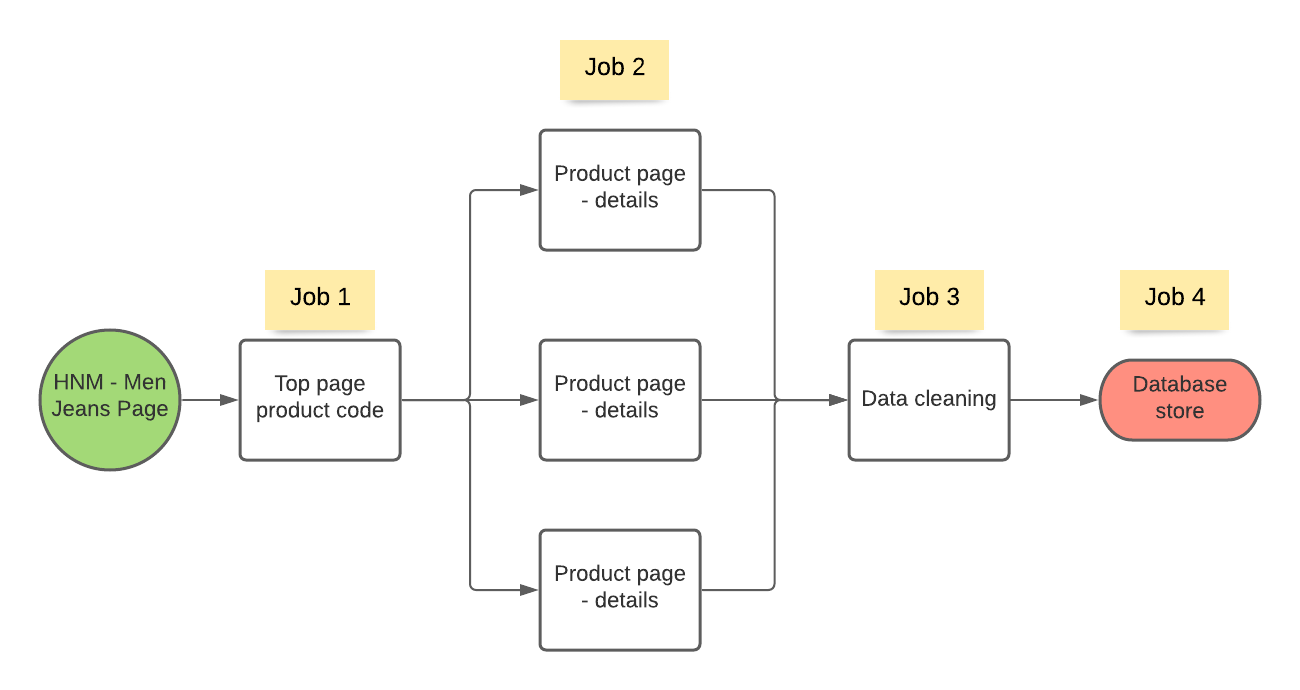

In [154]:
Image('../img/etl_architecture.png')

### Orquestração dos Jobs

1. Ferramenta para "rodar" o job automaticamente
2. Dependências entre os Jobs
3. Rodar novamente em caso de falha

### Arquivos de Log

1. Ferramenta para gerar e armazenar os Logs
2. Leitura e escrita dos Jobs

### Documentação

Tabela de agendamento dos Jobs e suas dependências